In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import netcomp as nc

In [138]:
##Load original data
full_energyharvestertensor = pd.read_excel(r'C:\Users\nandy\Downloads\functionalmodels\functionalmodels\energy_harvesters_tensor.xls', sheet_name=None, header=1, index_col=0) 
energyharvestertensor = pd.concat(full_energyharvestertensor, axis=1)
#appliancestensor = pd.read_csv(r'C:\Users\nandy\source\repos\FunctionalModelSimilarity\FunctionalModelSimilarity\data\02_intermediate\appliances_and_toys_adjacencymatrix_V2.csv', header=[0,1], index_col=0) 
#appliancestensor = appliancestensor.stack(0)
#appliancestensor = appliancestensor.unstack(0)
#energyharvestertensor = appliancestensor

# Expanding Data Using Probability Distribution

In [3]:
def functionflowprobability(df):
    probabilities = df.sum(axis=0)/df.shape[0]
    return probabilities.unstack()

In [4]:
prob_energyharvester = functionflowprobability(energyharvestertensor)

In [5]:
nobs_vec = [1000, 10000, 100000] #Size of dataset

In [6]:
def create_dataset(theta, nobs): #dictionary
    #theta is the probability of function-flow pair existing
    #nobs is the size of the dataset
    expanded_data = {}
    graphs = {}
    adj_matrices = {}
    for i in range(0, nobs):
        np.random.seed(i)
        Y = pd.DataFrame(np.random.binomial(n=1, p=theta), index=theta.index, columns=theta.columns)
        expanded_data[i] = Y
        df2 = pd.concat([expanded_data[i], expanded_data[i].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
        graphs[i] = nx.from_numpy_matrix(df2.values)
        adj_matrices[i] = nx.adjacency_matrix(graphs[i])
        mapping = dict(zip(graphs[i], df2.columns.values)) 
        graphs[i] = nx.relabel_nodes(graphs[i], mapping)
    return graphs, adj_matrices

In [7]:
g, a = create_dataset(prob_energyharvester, nobs_vec[0])

# Graph Properties

In [8]:
def maxofdict(d):
    mx_pair = max(zip(d.values(), d.keys()))
    return mx_pair

In [9]:
properties = pd.DataFrame()
for key in g:
    X, Y = nx.algorithms.bipartite.sets(g[key])
    deg_centrality = nx.algorithms.bipartite.centrality.degree_centrality(g[key],X)
    cent, nname = maxofdict(deg_centrality)
    properties.loc[key, "max_deg_centrality"] = cent
    properties.loc[key, "avg_deg_centrality"] = sum(deg_centrality.values())/len(deg_centrality)
    max_degree = nx.adjacency_matrix(g[key]).sum(axis=1).max()
    properties.loc[key, "max_degree"] = max_degree
    max_deg_nodes = [item[0] for item in g[key].degree() if item[1] == max_degree]
    max_deg_nodes_str = ','.join(max_deg_nodes)
    properties.loc[key, "max_deg_nodes"] = max_deg_nodes_str
    complexity = a[key].sum().sum()/2
    properties.loc[key, "complexity"] = complexity
    bi_clustering = nx.algorithms.bipartite.cluster.average_clustering(g[key])
    properties.loc[key, "bipartite clustering coeff"] = bi_clustering
    

(array([  4.,  30., 110., 221., 248., 202., 114.,  49.,  18.,   4.]),
 array([0.22712355, 0.23606061, 0.24499767, 0.25393473, 0.26287178,
        0.27180884, 0.2807459 , 0.28968295, 0.29862001, 0.30755707,
        0.31649412]),
 <a list of 10 Patch objects>)

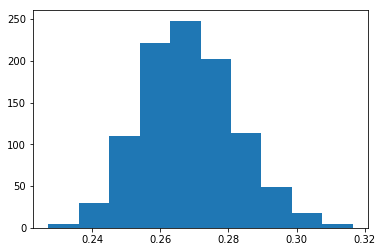

In [10]:
plt.hist(properties["bipartite clustering coeff"])

# Testing Graph Distances on Larger Dataset

In [60]:
df = pd.DataFrame()
for key1 in a:
    for key2 in a:
        A1 = a[key1]
        A2 = a[key2]
        d = nc.lambda_dist(A1,A2,kind='laplacian')
        df.loc[key1, key2] = d
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,3.741398,6.583571,5.649727,4.163598,4.764293,5.196858,4.677851,6.456252,6.718229,...,5.975338,4.141873,6.257522,4.943615,4.726777,3.353974,4.822401,5.085010,4.190306,5.995793
1,3.741398,0.000000,4.828650,4.066145,3.628028,3.290230,3.859171,2.941110,4.238119,4.373992,...,4.173917,3.173084,4.299587,3.448101,7.311371,2.944419,3.214633,3.837838,2.944187,4.921595
2,6.583571,4.828650,0.000000,2.663360,4.373961,5.625016,4.016957,3.272746,5.048475,2.168751,...,3.876289,3.689585,3.363322,3.893763,10.753432,5.110971,3.537650,2.709855,3.861227,6.181539
3,5.649727,4.066145,2.663360,0.000000,4.441326,4.696330,3.857928,2.639013,5.057825,3.015463,...,3.856141,2.986243,3.049674,3.867046,9.701384,4.207501,2.932115,2.497052,3.034888,6.307721
4,4.163598,3.628028,4.373961,4.441326,0.000000,3.567128,2.473852,2.817851,3.903492,4.035405,...,3.346523,2.674375,3.620023,2.910578,8.187174,2.775276,3.458384,3.370042,3.070175,3.560694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.353974,2.944419,5.110971,4.207501,2.775276,2.138696,3.016185,2.549284,4.248227,4.693398,...,3.462008,2.570587,3.853181,3.726994,6.974407,0.000000,2.900210,3.839404,1.960305,4.337106
496,4.822401,3.214633,3.537650,2.932115,3.458384,3.410412,3.630489,2.444143,4.778056,3.591155,...,3.448084,2.118235,3.375265,3.855234,8.313407,2.900210,0.000000,3.319007,2.198319,5.381384
497,5.085010,3.837838,2.709855,2.497052,3.370042,4.627754,2.574537,2.195783,4.036749,3.046986,...,3.275753,2.699397,2.971335,3.052549,9.406363,3.839404,3.319007,0.000000,2.883988,4.874642
498,4.190306,2.944187,3.861227,3.034888,3.070175,2.755821,2.976401,1.761911,3.914233,3.654097,...,2.645937,2.613873,3.142679,3.427704,7.962708,1.960305,2.198319,2.883988,0.000000,4.568973


In [39]:
import itertools

def dist(a1,a2):
    d = nc.lambda_dist(a1,a2,kind='laplacian')
    return d

[dist(*map(a.get, item)) for item in itertools.combinations(a,2)]

In [11]:
def create_dataset(theta, nobs): #np 3D array instead of dictionary
    #theta is the probability of function-flow pair existing
    #nobs is the size of the dataset
    expanded_data = {}
    graphs = {}
    adj_matrices = {}
    adj_array = []
    for i in range(0, nobs):
        np.random.seed(i)
        Y = pd.DataFrame(np.random.binomial(n=1, p=theta), index=theta.index, columns=theta.columns)
        expanded_data[i] = Y
        df2 = pd.concat([expanded_data[i], expanded_data[i].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
        graphs[i] = nx.from_numpy_matrix(df2.values)
        adj_array.append(df2.values)
        adj_matrices[i] = nx.adjacency_matrix(graphs[i])
        mapping = dict(zip(graphs[i], df2.columns.values)) 
        graphs[i] = nx.relabel_nodes(graphs[i], mapping)
    return graphs, adj_matrices, np.array(adj_array)

In [12]:
g2, a2, arr = create_dataset(prob_energyharvester, nobs_vec[0])

In [13]:
arr.shape

(1000, 37, 37)

In [14]:
arr[0,:,:].shape

(37, 37)

In [92]:
import numba as nb
@nb.jit()
def testfun(arr):
    df = np.zeros((arr.shape[0],arr.shape[0]))
    for i in range(0, arr.shape[0]):
        for j in range(0, arr.shape[0]):
            A1 = arr[i,:,:]
            A2 = arr[j,:,:]
            d = nc.lambda_dist(A1,A2,kind='laplacian')
            df[i,j] = d
    return df

print(testfun(arr).shape)

<ipython-input-92-daf03ee3e357>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "testfun" failed type inference due to: Unknown attribute 'lambda_dist' of type Module(<module 'netcomp' from 'C:\\Users\\nandy\\Anaconda3\\envs\\test_env\\lib\\site-packages\\netcomp\\__init__.py'>)

File "<ipython-input-92-daf03ee3e357>", line 10:
def testfun(arr):
    <source elided>
            A2 = arr[j,:,:]
            d = nc.lambda_dist(A1,A2,kind='laplacian')
            ^

[1] During: typing of get attribute at <ipython-input-92-daf03ee3e357> (10)

File "<ipython-input-92-daf03ee3e357>", line 10:
def testfun(arr):
    <source elided>
            A2 = arr[j,:,:]
            d = nc.lambda_dist(A1,A2,kind='laplacian')
            ^

  @nb.jit()
<ipython-input-92-daf03ee3e357>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "testfun" failed type inference due to: cannot determine Numba type

(1000, 1000)


C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\numba\compiler.py:742: NumbaWarning: Function "testfun" was compiled in object mode without forceobj=True.

File "<ipython-input-92-daf03ee3e357>", line 6:
def testfun(arr):
    <source elided>
    print(df.shape)
    for i in range(0, arr.shape[0]):
    ^

  self.func_ir.loc))
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\numba\compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-92-daf03ee3e357>", line 6:
def testfun(arr):
    <source elided>
    print(df.shape)
    for i in range(0, arr.shape[0]):
    ^

  warnings.warn(errors.NumbaDeprecationWarning(msg, self.func_ir.loc))


(1000, 1000)


# Looking for Bipartite-specific Properties

(array([512.,   0.,   0., 403.,   0.,   0.,   0.,   0.,   0.,  85.]),
 array([0.3128655 , 0.31342419, 0.31398287, 0.31454156, 0.31510025,
        0.31565894, 0.31621763, 0.31677632, 0.317335  , 0.31789369,
        0.31845238]),
 <a list of 10 Patch objects>)

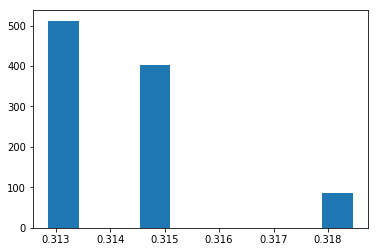

In [15]:
from networkx.algorithms import bipartite
test = []
for i in range(0,1000):
    G = g2[i]
    #print(bipartite.is_bipartite(G))
    X, Y = bipartite.sets(G)
    list(X), list(Y)
    Gc = max(nx.connected_component_subgraphs(g2[i]), key=len)
    #print(len(list(Gc.nodes())))
    #print(len(list(nx.connected_component_subgraphs(g2[i]))))
    test.append(bipartite.basic.density(g2[99],X))

plt.hist(test)

C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot

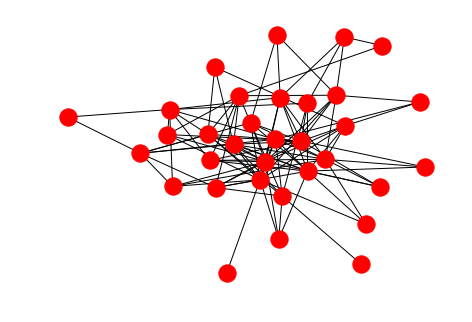

In [16]:
Gc = max(nx.connected_component_subgraphs(g2[99]), key=len)
nx.draw(Gc)

# Perturbation

In [139]:
np.random.seed(9999)
index = energyharvestertensor.iloc[np.random.randint(energyharvestertensor.shape[0])].name
np.random.seed(9998)
sourcename = energyharvestertensor.iloc[np.random.randint(energyharvestertensor.shape[0])].name
index, sourcename

('Columbia Power Manta buoy', 'Tracking system')

In [140]:
##try new method - swapping or negating rows to test global vs local structure (only done on one functional model)
negated1 = {}
negated2 = {}
swapped = {}
graphs_n1 = {}
adj_matrices_n1 = {}
graphs_n2 = {}
adj_matrices_n2 = {}
graphs_s = {}
adj_matrices_s = {}
#index = "Wing Wave Generator"
original = energyharvestertensor.loc[index].unstack()
orig_df = pd.concat([original, original.T], sort=True).fillna(0).sort_index()
orig_g = nx.from_numpy_matrix(orig_df.values)
orig_adj = nx.adjacency_matrix(orig_g)

for j in range(0,original.shape[1]):
    for k in range(0, original.shape[1]):
        if k>j:
            modified = original.copy()
            name = str(j)+str(k)
            cols1, cols2 = np.logical_not(modified.iloc[:,j].copy()).astype(int), modified.iloc[:,k].copy()
            modified.iloc[:,j], modified.iloc[:,k] = cols1.values, cols2.values
            negated1[name] = modified
            df2 = pd.concat([negated1[name], negated1[name].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
            graphs_n1[name] = nx.from_numpy_matrix(df2.values)
            adj_matrices_n1[name] = nx.adjacency_matrix(graphs_n1[name])
            mapping = dict(zip(graphs_n1[name], df2.columns.values)) 
            graphs_n1[name] = nx.relabel_nodes(graphs_n1[name], mapping)
for j in range(0,original.shape[1]):
    for k in range(0, original.shape[1]):
        if k>j:
            modified = original.copy()
            name = str(j)+str(k)
            cols1, cols2 = np.logical_not(modified.iloc[:,j].copy()).astype(int), np.logical_not(modified.iloc[:,k].copy()).astype(int)
            modified.iloc[:,j], modified.iloc[:,k] = cols1.values, cols2.values
            negated2[name] = modified
            df2 = pd.concat([negated2[name], negated2[name].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
            graphs_n2[name] = nx.from_numpy_matrix(df2.values)
            adj_matrices_n2[name] = nx.adjacency_matrix(graphs_n2[name])
            mapping = dict(zip(graphs_n2[name], df2.columns.values)) 
            graphs_n2[name] = nx.relabel_nodes(graphs_n2[name], mapping)
for j in range(0,original.shape[1]):
    for k in range(0, original.shape[1]):
        if k>j:
            modified = original.copy()
            name = str(j)+str(k)
            cols1, cols2 = modified.iloc[:,j].copy(), modified.iloc[:,k].copy()
            modified.iloc[:,j], modified.iloc[:,k] = cols2.values, cols1.values
            swapped[name] = modified
            df2 = pd.concat([swapped[name], swapped[name].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
            graphs_s[name] = nx.from_numpy_matrix(df2.values)
            adj_matrices_s[name] = nx.adjacency_matrix(graphs_s[name])
            mapping = dict(zip(graphs_s[name], df2.columns.values)) 
            graphs_s[name] = nx.relabel_nodes(graphs_s[name], mapping) 

In [141]:
def range_normalize(data):
    normalized = 1 - ((data - data.min().min())/(data.max().max() - data.min().min()))
    return normalized

In [142]:
df1 = pd.DataFrame()
A1 = orig_adj
for key in adj_matrices_n1:
        A2 = adj_matrices_n1[key]
        d1 = nc.lambda_dist(A1,A2,kind='laplacian')
        df1.loc["Flip 1 Column", key] = d1
        A3 = adj_matrices_s[key]
        d2 = nc.lambda_dist(A1, A3, kind='laplacian')
        df1.loc["Swap Columns", key] = d2 
        A4 = adj_matrices_n2[key]
        d3 = nc.lambda_dist(A1, A4, kind='laplacian')
        df1.loc["Flip 2 Columns", key] = d3

In [143]:
df2 = pd.DataFrame()
A1 = orig_adj
for key in adj_matrices_n1:
        A2 = adj_matrices_n1[key]
        d1 = nc.edit_distance(A1,A2)
        df2.loc["Flip 1 Column", key] = d1
        A3 = adj_matrices_s[key]
        d2 = nc.edit_distance(A1, A3)
        df2.loc["Swap Columns", key] = d2 
        A4 = adj_matrices_n2[key]
        d3 = nc.edit_distance(A1, A4)
        df2.loc["Flip 2 Columns", key] = d3
df2

,01,02,03,04,05,06,07,08,09,010,...,1112,1113,1114,1115,1213,1214,1215,1314,1315,1415
Flip 1 Column,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,...,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
Swap Columns,0.0,0.0,22.0,0.0,0.0,22.0,0.0,0.0,22.0,22.0,...,0.0,22.0,0.0,22.0,22.0,0.0,22.0,22.0,0.0,22.0
Flip 2 Columns,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,...,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0


In [144]:
df3 = pd.DataFrame()
A1 = orig_adj
for key in adj_matrices_n1:
        A2 = adj_matrices_n1[key]
        d1 = nc.deltacon0(A1,A2)
        df3.loc["Flip 1 Column", key] = d1
        A3 = adj_matrices_s[key]
        d2 = nc.deltacon0(A1, A3)
        df3.loc["Swap Columns", key] = d2
        A4 = adj_matrices_n2[key]
        d3 = nc.deltacon0(A1, A4)
        df3.loc["Flip 2 Columns", key] = d3
df3

,01,02,03,04,05,06,07,08,09,010,...,1112,1113,1114,1115,1213,1214,1215,1314,1315,1415
Flip 1 Column,77.149392,77.149392,77.149392,77.149392,77.149392,77.149392,77.149392,77.149392,77.149392,77.149392,...,32.612895,32.612895,32.612895,32.612895,32.612895,32.612895,32.612895,77.149392,77.149392,32.612895
Swap Columns,0.000000,0.000000,24.824174,0.000000,0.000000,24.824174,0.000000,0.000000,24.824174,24.824174,...,0.000000,24.824174,0.000000,24.824174,24.824174,0.000000,24.824174,24.824174,0.000000,24.824174
Flip 2 Columns,96.783364,96.783364,89.942751,96.783364,96.783364,89.942751,96.783364,96.783364,89.942751,89.942751,...,58.420979,89.942751,58.420979,89.942751,89.942751,58.420979,89.942751,89.942751,96.783364,89.942751


In [145]:
import scipy
df4 = pd.DataFrame()
A1 = original.to_numpy().flatten()
for key in adj_matrices_n1:
        A2 = negated1[key].to_numpy().flatten()
        d1 = scipy.spatial.distance.jaccard(A1,A2)
        df4.loc["Flip 1 Column", key] = d1
        A3 = swapped[key].to_numpy().flatten()
        d2 = scipy.spatial.distance.jaccard(A1,A3)
        df4.loc["Swap Columns", key] = d2
        A4 = negated2[key].to_numpy().flatten()
        d3 = scipy.spatial.distance.jaccard(A1,A4)
        df4.loc["Flip 2 Columns", key] = d3
df4

,01,02,03,04,05,06,07,08,09,010,...,1112,1113,1114,1115,1213,1214,1215,1314,1315,1415
Flip 1 Column,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,...,0.241379,0.241379,0.241379,0.241379,0.241379,0.241379,0.241379,0.214286,0.214286,0.241379
Swap Columns,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.250000,...,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000
Flip 2 Columns,0.352941,0.352941,0.388889,0.352941,0.352941,0.388889,0.352941,0.352941,0.388889,0.388889,...,0.432990,0.388889,0.432990,0.388889,0.388889,0.432990,0.388889,0.388889,0.352941,0.388889


In [146]:
df5 = pd.DataFrame()
A1 = original.to_numpy().flatten()
for key in adj_matrices_n1:
        A2 = negated1[key].to_numpy().flatten()
        d1 = scipy.spatial.distance.cosine(A1,A2)
        df5.loc["Flip 1 Column", key] = d1
        A3 = swapped[key].to_numpy().flatten()
        d2 = scipy.spatial.distance.cosine(A1,A3)
        df5.loc["Swap Columns", key] = d2
        A4 = negated2[key].to_numpy().flatten()
        d3 = scipy.spatial.distance.cosine(A1,A4)
        df5.loc["Flip 2 Columns", key] = d3
df5

,01,02,03,04,05,06,07,08,09,010,...,1112,1113,1114,1115,1213,1214,1215,1314,1315,1415
Flip 1 Column,0.113595,0.113595,0.113595,0.113595,0.113595,0.113595,0.113595,0.113595,0.113595,0.113595,...,0.137236,0.137236,0.137236,0.137236,0.137236,0.137236,0.137236,0.113595,0.113595,0.137236
Swap Columns,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.142857,...,0.000000,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857
Flip 2 Columns,0.195600,0.195600,0.236318,0.195600,0.195600,0.236318,0.195600,0.195600,0.236318,0.236318,...,0.276253,0.236318,0.276253,0.236318,0.236318,0.276253,0.236318,0.236318,0.195600,0.236318


Text(0.5,0.98,'Similarity of Perturbed Model to Original (Range Normalized)')

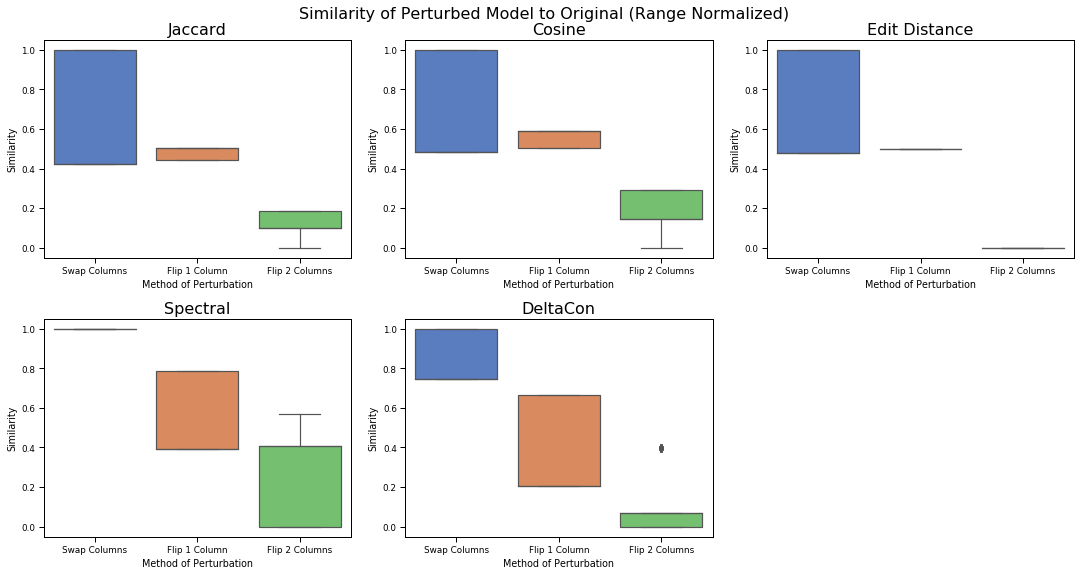

In [147]:
sns.set_context("paper")
sns.set_palette('muted')
f, axes = plt.subplots(2, 3, figsize=(15,8), constrained_layout=True)
sns.boxplot(data=range_normalize(df1).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[1,0])
sns.boxplot(data=range_normalize(df2).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[0,2])
sns.boxplot(data=range_normalize(df3).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[1,1])
sns.boxplot(data=range_normalize(df4).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[0,0])
sns.boxplot(data=range_normalize(df5).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[0,1])
axes[0,0].set_title("Jaccard", fontsize=16)
axes[0,1].set_title("Cosine", fontsize=16)
axes[0,2].set_title("Edit Distance", fontsize=16)
axes[1,0].set_title("Spectral", fontsize=16)
axes[1,1].set_title("DeltaCon", fontsize=16)
axes[1,2].axis('off')
for i in range(0,2):
    for j in range(0,3):
        axes[i,j].set(ylabel = "Similarity", xlabel = "Method of Perturbation")
f.suptitle("Similarity of Perturbed Model to Original (Range Normalized)", fontsize=16);

# Subgraph matching

In [148]:
match_size = range(2,14)
trials = 100

In [149]:
##try new method - swapping or negating rows to test global vs local structure (only done on one functional model)
subgraph_match = {}
random_match = {}
graphs_sm = {}
adj_matrices_sm = {}
graphs_rm = {}
adj_matrices_rm = {}
#index = "Wing Wave Generator"
original = energyharvestertensor.loc[index].unstack()
orig_df = pd.concat([original, original.T], sort=True).fillna(0).sort_index()
orig_g = nx.from_numpy_matrix(orig_df.values)
orig_adj = nx.adjacency_matrix(orig_g)

#sourcename = "Seiko Kinetic watch"
source = energyharvestertensor.loc[sourcename].unstack()
source_df = pd.concat([source, source.T], sort=True).fillna(0).sort_index()
source_g = nx.from_numpy_matrix(source_df.values)
source_adj = nx.adjacency_matrix(source_g)

for size in match_size:
    for i in range(0,trials):
        np.random.seed(i)
        name = str(size)+','+str(i)
        modified = original.copy()
        modified2 = original.copy()
        row_ix = np.random.choice(original.shape[0], size**2)
        col_ix = np.random.choice(original.shape[1], size**2)
        for k in range(0,len(row_ix)):
            modified.iloc[row_ix[k], col_ix[k]] = source.iloc[row_ix[k], col_ix[k]]
        random_match[name] = modified
        df2 = pd.concat([random_match[name], random_match[name].T], sort=True).fillna(0).sort_index() 
        graphs_rm[name] = nx.from_numpy_matrix(df2.values)
        adj_matrices_rm[name] = nx.adjacency_matrix(graphs_rm[name])
        mapping = dict(zip(graphs_rm[name], df2.columns.values)) 
        graphs_rm[name] = nx.relabel_nodes(graphs_rm[name], mapping)
        
        np.random.seed(i+trials)
        rowstart = np.random.randint(original.shape[0] - size)
        colstart = np.random.randint(original.shape[1] - size)
        modified2.iloc[rowstart:rowstart+size,colstart:colstart+size] = source.iloc[rowstart:rowstart+size,colstart:colstart+size]
        subgraph_match[name] = modified2
        df2 = pd.concat([subgraph_match[name], subgraph_match[name].T], sort=True).fillna(0).sort_index() 
        graphs_sm[name] = nx.from_numpy_matrix(df2.values)
        adj_matrices_sm[name] = nx.adjacency_matrix(graphs_sm[name])
        mapping = dict(zip(graphs_sm[name], df2.columns.values)) 
        graphs_sm[name] = nx.relabel_nodes(graphs_sm[name], mapping)

In [150]:
df6 = pd.DataFrame()
A1 = orig_adj
A2 = source_adj
origsourcedist = nc.lambda_dist(A1,A2, kind='laplacian')
for key in adj_matrices_rm:
        d1 = nc.lambda_dist(A1,adj_matrices_rm[key],kind='laplacian')
        df6.loc["random_match original", key] = d1
        d2 = nc.lambda_dist(A2, adj_matrices_rm[key], kind='laplacian')
        df6.loc["random_match source", key] = d2 
        d3 = nc.lambda_dist(A1,adj_matrices_sm[key], kind='laplacian')
        df6.loc["subgraph_match original", key] = d3
        d4 = nc.lambda_dist(A2,adj_matrices_sm[key], kind='laplacian')
        df6.loc["subgraph_match source", key] = d4
df6

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,1.327254,2.828427,2.285817,1.971347,0.000000,1.909751,2.434773,1.327254,1.388567,1.936085,...,13.148241,11.788640,12.056602,16.542088,13.632520,12.183053,12.538782,11.356156,15.346343,12.549052
random_match source,26.459617,25.258662,25.203670,25.749880,26.191602,26.240254,25.505267,26.459617,25.971496,25.462544,...,20.839371,21.072320,20.854135,17.858469,21.873089,20.648601,20.782495,22.142123,17.238456,21.987488
subgraph_match original,0.000000,0.000000,2.153270,1.343576,0.000000,2.174676,2.347100,2.285817,0.000000,0.000000,...,12.879542,12.877305,12.877305,15.544490,13.727195,12.877305,14.300581,12.877305,12.879542,17.153836
subgraph_match source,26.191602,26.191602,26.733275,25.686673,26.191602,26.219999,25.209301,25.203670,26.191602,26.191602,...,21.421585,23.320055,23.320055,19.535382,21.964423,23.320055,19.885040,23.320055,21.421585,17.891412


In [151]:
def reformat_for_plot(data):
    indexrow = [int(item.split(',')[0]) for item in list(data.columns.values)]
    new = data.loc[["random_match original", "subgraph_match original"],:]
    new = range_normalize(new)
    new.loc["size",:] = indexrow
    new = pd.melt(new.T, id_vars=['size'])
    new['value']=new['value'].astype(float)
    return new
def reformat_for_plot2(data, origsourcedist):
    indexrow = [int(item.split(',')[0]) for item in list(data.columns.values)]
    new = data.loc[["random_match source", "subgraph_match source"],:]
    new = 1 - ((new - new.min().min())/(new.max().max() - new.min().min()))
    new.loc["size",:] = indexrow
    new = pd.melt(new.T, id_vars=['size'])
    new['value']=new['value'].astype(float)
    return new

In [152]:
df7 = pd.DataFrame()
A1 = orig_adj
A2 = source_adj
origsourcedist = nc.edit_distance(A1, A2)
for key in adj_matrices_rm:
        d1 = nc.edit_distance(A1,adj_matrices_rm[key])
        df7.loc["random_match original", key] = d1
        d2 = nc.edit_distance(A2, adj_matrices_rm[key])
        df7.loc["random_match source", key] = d2 
        d3 = nc.edit_distance(A1,adj_matrices_sm[key])
        df7.loc["subgraph_match original", key] = d3
        d4 = nc.edit_distance(A2,adj_matrices_sm[key])
        df7.loc["subgraph_match source", key] = d4
df7

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,1.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,1.0,2.0,...,56.0,59.0,52.0,68.0,57.0,59.0,59.0,53.0,63.0,56.0
random_match source,142.0,141.0,141.0,141.0,143.0,141.0,141.0,142.0,142.0,141.0,...,87.0,84.0,91.0,75.0,86.0,84.0,84.0,90.0,80.0,87.0
subgraph_match original,0.0,0.0,2.0,1.0,0.0,4.0,2.0,2.0,0.0,0.0,...,54.0,58.0,58.0,61.0,62.0,58.0,54.0,58.0,54.0,60.0
subgraph_match source,143.0,143.0,141.0,142.0,143.0,139.0,141.0,141.0,143.0,143.0,...,89.0,85.0,85.0,82.0,81.0,85.0,89.0,85.0,89.0,83.0


In [153]:
df8 = pd.DataFrame()
A1 = orig_adj
A2 = source_adj
origsourcedist = (A1,A2)
for key in adj_matrices_rm:
        d1 = nc.deltacon0(A1,adj_matrices_rm[key])
        df8.loc["random_match original", key] = d1
        d2 = nc.deltacon0(A2, adj_matrices_rm[key])
        df8.loc["random_match source", key] = d2 
        d3 = nc.deltacon0(A1,adj_matrices_sm[key])
        df8.loc["subgraph_match original", key] = d3
        d4 = nc.deltacon0(A2,adj_matrices_sm[key])
        df8.loc["subgraph_match source", key] = d4
df8

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,1.963341,1.150780,24.718901,7.447741,0.000000,5.622957,4.276151,1.963341,3.700761,17.200384,...,101.509996,105.003875,100.324640,116.282171,105.949369,103.304319,105.696528,99.253866,114.471693,101.221628
random_match source,165.129619,166.082570,145.403509,163.912489,167.092959,163.580426,165.020642,165.129619,165.525837,153.496113,...,83.514446,81.669517,88.475427,75.464223,81.990414,85.622880,79.050166,85.384058,79.155482,85.464981
subgraph_match original,0.000000,0.000000,3.812722,13.896286,0.000000,8.682328,15.404219,24.718901,0.000000,0.000000,...,94.006756,88.501935,88.501935,101.725886,92.071172,88.501935,94.364826,88.501935,94.006756,100.007999
subgraph_match source,167.092959,167.092959,163.280237,154.972353,167.092959,161.170463,154.326551,145.403509,167.092959,167.092959,...,87.615483,90.669272,90.669272,79.205222,88.004629,90.669272,91.641301,90.669272,87.615483,86.504820


In [154]:
df9 = pd.DataFrame()
A1 = original.to_numpy().flatten()
A2 = source.to_numpy().flatten()
origsourcedist = scipy.spatial.distance.jaccard(A1,A2)
for key in adj_matrices_rm:
        d1 = scipy.spatial.distance.jaccard(A1,random_match[key].to_numpy().flatten())
        df9.loc["random_match original", key] = d1
        d2 = scipy.spatial.distance.jaccard(A2,random_match[key].to_numpy().flatten())
        df9.loc["random_match source", key] = d2 
        d3 = scipy.spatial.distance.jaccard(A1,subgraph_match[key].to_numpy().flatten())
        df9.loc["subgraph_match original", key] = d3
        d4 = scipy.spatial.distance.jaccard(A2,subgraph_match[key].to_numpy().flatten())
        df9.loc["subgraph_match source", key] = d4
df9

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,0.012987,0.025316,0.025316,0.025316,0.00000,0.025641,0.025316,0.012987,0.012821,0.025316,...,0.486957,0.517544,0.460177,0.535433,0.500000,0.508621,0.508621,0.473214,0.504000,0.495575
random_match source,0.825581,0.815029,0.815029,0.815029,0.82659,0.819767,0.815029,0.825581,0.820809,0.815029,...,0.561290,0.556291,0.579618,0.483871,0.562092,0.549020,0.549020,0.580645,0.506329,0.568627
subgraph_match original,0.000000,0.000000,0.025974,0.012821,0.00000,0.050633,0.025316,0.025316,0.000000,0.000000,...,0.495413,0.542056,0.542056,0.530435,0.558559,0.542056,0.486486,0.542056,0.495413,0.512821
subgraph_match source,0.826590,0.826590,0.824561,0.820809,0.82659,0.812865,0.815029,0.815029,0.826590,0.826590,...,0.589404,0.586207,0.586207,0.546667,0.558621,0.586207,0.581699,0.586207,0.589404,0.542484


In [155]:
df10 = pd.DataFrame()
A1 = original.to_numpy().flatten()
A2 = source.to_numpy().flatten()
origsourcedist = scipy.spatial.distance.cosine(A1,A2)
for key in adj_matrices_rm:
        d1 = scipy.spatial.distance.cosine(A1, random_match[key].to_numpy().flatten())
        df10.loc["random_match original", key] = d1
        d2 = scipy.spatial.distance.cosine(A2, random_match[key].to_numpy().flatten())
        df10.loc["random_match source", key] = d2 
        d3 = scipy.spatial.distance.cosine(A1, subgraph_match[key].to_numpy().flatten())
        df10.loc["subgraph_match original", key] = d3
        d4 = scipy.spatial.distance.cosine(A2,subgraph_match[key].to_numpy().flatten())
        df10.loc["subgraph_match source", key] = d4
df10

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,0.006515,0.012739,0.012739,0.012739,0.000000,0.012987,0.012739,0.006515,0.006431,0.012739,...,0.317314,0.346533,0.294172,0.355989,0.330014,0.337030,0.337030,0.306506,0.326326,0.326422
random_match source,0.693430,0.679261,0.679261,0.679261,0.695428,0.685275,0.679261,0.693430,0.687299,0.679261,...,0.384911,0.377706,0.403002,0.317360,0.384362,0.372624,0.372624,0.402739,0.337459,0.390299
subgraph_match original,0.000000,0.000000,0.013072,0.006431,0.000000,0.025974,0.012739,0.012739,0.000000,0.000000,...,0.328018,0.371743,0.371743,0.358415,0.387069,0.371743,0.319060,0.371743,0.328018,0.340456
subgraph_match source,0.695428,0.695428,0.691393,0.687299,0.695428,0.675123,0.679261,0.679261,0.695428,0.695428,...,0.407829,0.398615,0.398615,0.368418,0.374171,0.398615,0.402313,0.398615,0.407829,0.366820


Text(0.5,0.98,'Similarity of Perturbed Model to Source (Range Normalized)')

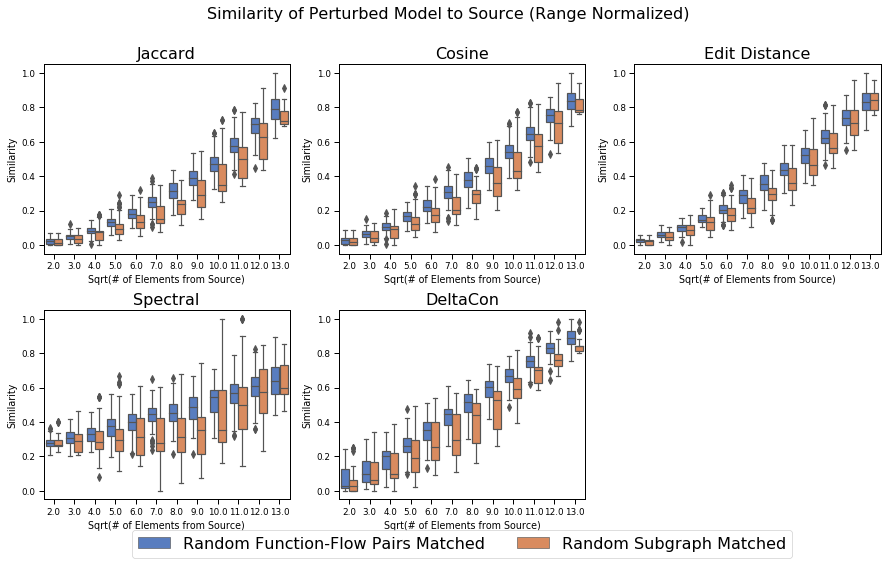

In [163]:
sns.set_context("paper")
sns.set_palette('muted')
f, axes = plt.subplots(2, 3, figsize=(15,8))
sns.boxplot(data=reformat_for_plot2(df6, origsourcedist), x='size',y='value', hue='variable', ax=axes[1,0])
sns.boxplot(data=reformat_for_plot2(df7, origsourcedist), x='size',y='value', hue='variable', ax=axes[0,2])
sns.boxplot(data=reformat_for_plot2(df8, origsourcedist), x='size',y='value', hue='variable', ax=axes[1,1])
sns.boxplot(data=reformat_for_plot2(df9, origsourcedist), x='size',y='value', hue='variable', ax=axes[0,0])
sns.boxplot(data=reformat_for_plot2(df10, origsourcedist), x='size',y='value', hue='variable', ax=axes[0,1])
axes[0,0].set_title("Jaccard", fontsize=16)
axes[0,1].set_title("Cosine", fontsize=16)
axes[0,2].set_title("Edit Distance", fontsize=16)
axes[1,0].set_title("Spectral", fontsize=16)
axes[1,1].set_title("DeltaCon", fontsize=16)
axes[1,2].axis('off')
axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[0,2].get_legend().remove()
axes[1,0].get_legend().remove()
for i in range(0,2):
    for j in range(0,3):
        axes[i,j].set(ylabel = "Similarity", xlabel = "Sqrt(# of Elements from Source)")
axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 16})
leg = axes[1,1].get_legend()
new_labels = ['Random Function-Flow Pairs Matched','Random Subgraph Matched']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
f.subplots_adjust(hspace=0.3)
f.suptitle("Similarity of Perturbed Model to Source (Range Normalized)", fontsize=16)

# Drawing Random Bipartite Graph

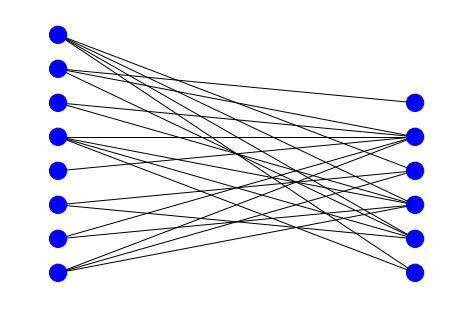

In [8]:
from networkx.algorithms import bipartite
q = nx.algorithms.bipartite.generators.random_graph(8,6,0.41)
X, Y = bipartite.sets(q)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(q, pos=pos, node_color=['blue','blue','blue','blue','blue','blue','blue', 'blue','blue','blue','blue','blue','blue','blue'])
plt.show()